<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/HistGradientBoostingClassifier(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [4]:

# Step 1: Load the datasets
print("Step 1: Loading datasets...")
train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {validation_df.shape}")
print(f"Test data shape: {test_df.shape}")


Step 1: Loading datasets...
Training data shape: (3584, 84)
Validation data shape: (768, 84)
Test data shape: (768, 84)


In [5]:

# Step 2: Data preprocessing and label creation
def create_quantile_labels(df, production_col='Production (M.Ton)'):
    """Create 5 quantile-based labels for production"""
    # Calculate quantiles on training data only
    if 'train' in locals() or df is train_df:
        quantiles = df[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values
        # Store quantiles globally for consistent labeling
        global quantile_boundaries
        quantile_boundaries = quantiles
    else:
        # Use stored quantiles for validation and test sets
        quantiles = quantile_boundaries

    # Create labels based on quantiles
    labels = []
    for value in df[production_col]:
        if value <= quantiles[0]:
            labels.append('Very Low')
        elif value <= quantiles[1]:
            labels.append('Low')
        elif value <= quantiles[2]:
            labels.append('Medium')
        elif value <= quantiles[3]:
            labels.append('High')
        else:
            labels.append('Very High')

    return labels

print("\nStep 2: Creating quantile-based labels...")
# Create labels for all datasets
train_df['Production_Label'] = create_quantile_labels(train_df)
validation_df['Production_Label'] = create_quantile_labels(validation_df)
test_df['Production_Label'] = create_quantile_labels(test_df)

# Print label distribution
print("Training set label distribution:")
print(train_df['Production_Label'].value_counts())



Step 2: Creating quantile-based labels...
Training set label distribution:
Production_Label
Very High    717
Very Low     717
Low          717
High         717
Medium       716
Name: count, dtype: int64


In [6]:

# Step 3: Prepare features and target variables
def prepare_features_target(df):
    """Prepare features and target variables"""
    # Remove the original production column and use the label
    X = df.drop(['Production (M.Ton)', 'Production_Label'], axis=1)
    y = df['Production_Label']

    return X, y

print("\nStep 3: Preparing features and target variables...")
X_train, y_train = prepare_features_target(train_df)
X_val, y_val = prepare_features_target(validation_df)
X_test, y_test = prepare_features_target(test_df)

# Encode categorical target variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Feature shape: {X_train.shape}")
print(f"Target classes: {label_encoder.classes_}")



Step 3: Preparing features and target variables...
Feature shape: (3584, 83)
Target classes: ['High' 'Low' 'Medium' 'Very High' 'Very Low']


In [7]:

# Step 4: Initialize and train the HistGradientBoostingClassifier
print("\nStep 4: Training HistGradientBoostingClassifier...")

# Initialize the model
model = HistGradientBoostingClassifier(
    max_iter=100,  # This acts like epochs
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=1
)

# Lists to store training history
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

# Manual training loop to track progress (simulating epochs)
print("Training with epoch-wise evaluation...")
for epoch in range(1, 101, 10):  # Check every 10 iterations
    # Train model with limited iterations
    temp_model = HistGradientBoostingClassifier(
        max_iter=epoch,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    temp_model.fit(X_train, y_train_encoded)

    # Predictions
    train_pred = temp_model.predict(X_train)
    val_pred = temp_model.predict(X_val)

    # Calculate metrics
    train_acc = accuracy_score(y_train_encoded, train_pred)
    val_acc = accuracy_score(y_val_encoded, val_pred)
    train_f1 = f1_score(y_train_encoded, train_pred, average='macro')
    val_f1 = f1_score(y_val_encoded, val_pred, average='macro')

    # Store metrics
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

# Final model training
final_model = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
final_model.fit(X_train, y_train_encoded)



Step 4: Training HistGradientBoostingClassifier...
Training with epoch-wise evaluation...
Epoch 1: Train Acc: 0.7494, Val Acc: 0.7005, Train F1: 0.7498, Val F1: 0.7008
Epoch 11: Train Acc: 0.8209, Val Acc: 0.7565, Train F1: 0.8214, Val F1: 0.7579
Epoch 21: Train Acc: 0.8557, Val Acc: 0.7682, Train F1: 0.8563, Val F1: 0.7694
Epoch 31: Train Acc: 0.8792, Val Acc: 0.7773, Train F1: 0.8797, Val F1: 0.7784
Epoch 41: Train Acc: 0.8984, Val Acc: 0.7865, Train F1: 0.8988, Val F1: 0.7872
Epoch 51: Train Acc: 0.9166, Val Acc: 0.7995, Train F1: 0.9168, Val F1: 0.8006
Epoch 61: Train Acc: 0.9300, Val Acc: 0.7995, Train F1: 0.9302, Val F1: 0.8004
Epoch 71: Train Acc: 0.9408, Val Acc: 0.8112, Train F1: 0.9410, Val F1: 0.8122
Epoch 81: Train Acc: 0.9548, Val Acc: 0.8177, Train F1: 0.9549, Val F1: 0.8186
Epoch 91: Train Acc: 0.9646, Val Acc: 0.8229, Train F1: 0.9647, Val F1: 0.8232


HistGradientBoostingClassifier(max_depth=6, random_state=42)

In [8]:

# Step 5: Model evaluation function
def evaluate_model(model, X, y_true, y_encoded, dataset_name):
    """Comprehensive model evaluation"""
    print(f"\n=== {dataset_name} Set Evaluation ===")

    # Predictions
    y_pred_encoded = model.predict(X)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculate metrics
    accuracy = accuracy_score(y_encoded, y_pred_encoded)
    precision = precision_score(y_encoded, y_pred_encoded, average='weighted')
    recall = recall_score(y_encoded, y_pred_encoded, average='weighted')
    f1_weighted = f1_score(y_encoded, y_pred_encoded, average='weighted')
    f1_macro = f1_score(y_encoded, y_pred_encoded, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

    # Classification report
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true, y_pred))

    return y_pred_encoded, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }


In [9]:
# Step 6: Evaluate on all datasets
print("\nStep 6: Model Evaluation...")

# Validation set evaluation
val_pred_encoded, val_metrics = evaluate_model(final_model, X_val, y_val, y_val_encoded, "Validation")

# Test set evaluation
test_pred_encoded, test_metrics = evaluate_model(final_model, X_test, y_test, y_test_encoded, "Test")




Step 6: Model Evaluation...

=== Validation Set Evaluation ===
Accuracy: 0.8190
Precision (Weighted): 0.8206
Recall (Weighted): 0.8190
F1 Score (Weighted): 0.8197
F1 Score (Macro): 0.8191

Classification Report for Validation:
              precision    recall  f1-score   support

        High       0.73      0.73      0.73       157
         Low       0.82      0.81      0.82       147
      Medium       0.73      0.75      0.74       153
   Very High       0.86      0.88      0.87       151
    Very Low       0.96      0.93      0.94       160

    accuracy                           0.82       768
   macro avg       0.82      0.82      0.82       768
weighted avg       0.82      0.82      0.82       768


=== Test Set Evaluation ===
Accuracy: 0.8281
Precision (Weighted): 0.8308
Recall (Weighted): 0.8281
F1 Score (Weighted): 0.8290
F1 Score (Macro): 0.8268

Classification Report for Test:
              precision    recall  f1-score   support

        High       0.74      0.73      0.

In [10]:
# Step 7: Plotting functions
def plot_confusion_matrix(y_true, y_pred, title, labels):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_training_history():
    """Plot training vs validation metrics"""
    epochs = list(range(1, 101, 10))

    # Plot accuracy
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1_scores, 'b-', label='Training Macro F1', marker='o')
    plt.plot(epochs, val_f1_scores, 'r-', label='Validation Macro F1', marker='s')
    plt.title('Model Macro F1 Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



Step 8: Generating visualizations...


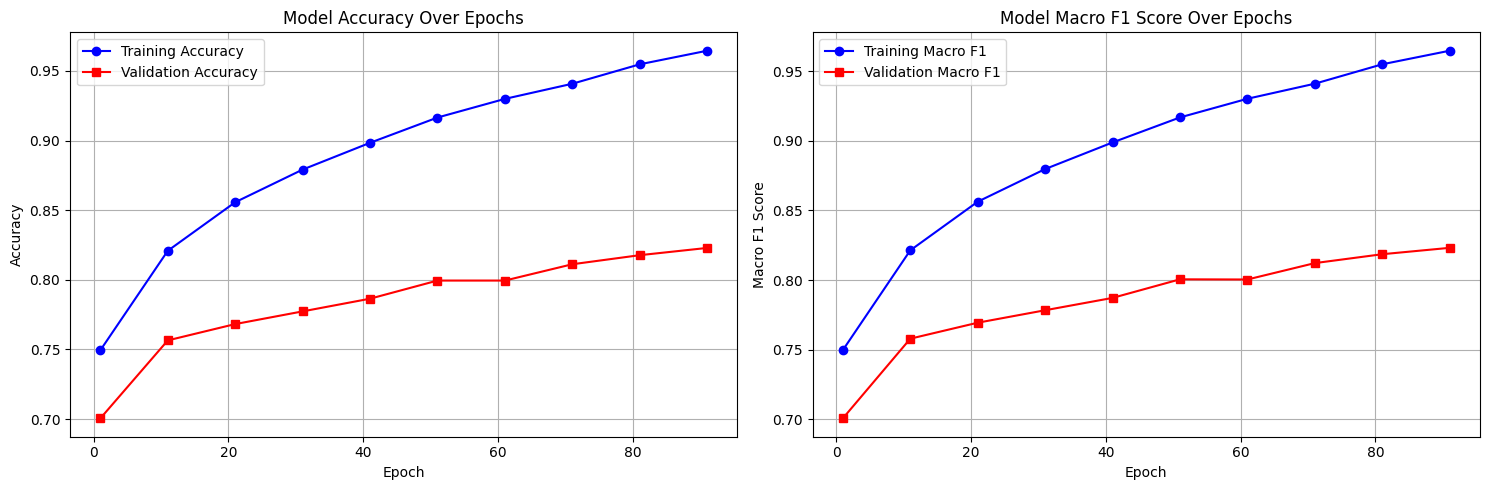

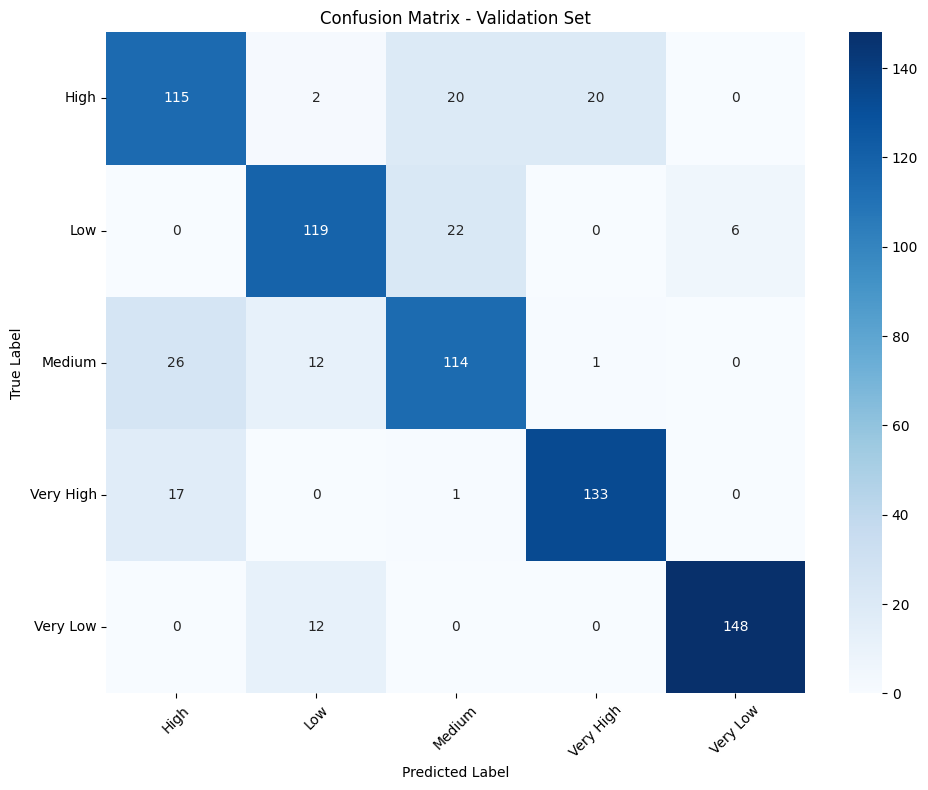

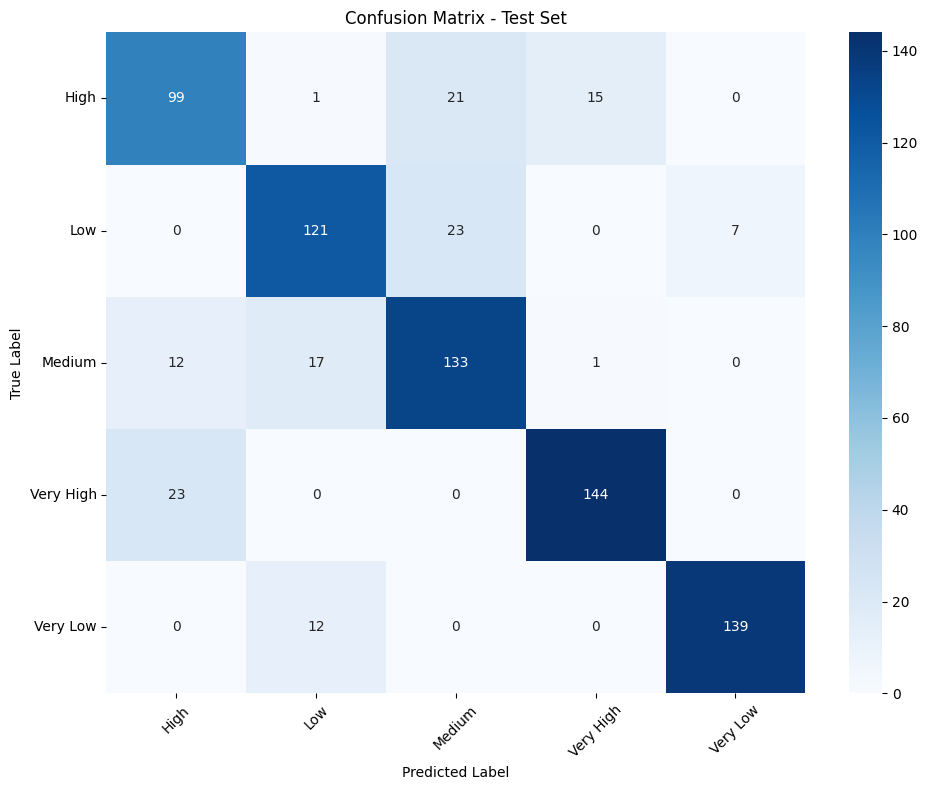

In [11]:


# Step 8: Generate all plots
print("\nStep 8: Generating visualizations...")

# Plot training history
plot_training_history()

# Plot confusion matrices
class_labels = label_encoder.classes_

# Validation confusion matrix
plot_confusion_matrix(y_val_encoded, val_pred_encoded, "Validation Set", class_labels)

# Test confusion matrix
plot_confusion_matrix(y_test_encoded, test_pred_encoded, "Test Set", class_labels)


In [12]:

# Step 9: Summary metrics table
print("\nStep 9: Final Summary...")
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

summary_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_metrics['accuracy'], test_metrics['accuracy']],
    'Precision (Weighted)': [val_metrics['precision'], test_metrics['precision']],
    'Recall (Weighted)': [val_metrics['recall'], test_metrics['recall']],
    'F1 Score (Weighted)': [val_metrics['f1_weighted'], test_metrics['f1_weighted']],
    'F1 Score (Macro)': [val_metrics['f1_macro'], test_metrics['f1_macro']]
})

print(summary_df.round(4))



Step 9: Final Summary...
FINAL MODEL PERFORMANCE SUMMARY
      Dataset  Accuracy  Precision (Weighted)  Recall (Weighted)  \
0  Validation    0.8190                0.8206             0.8190   
1        Test    0.8281                0.8308             0.8281   

   F1 Score (Weighted)  F1 Score (Macro)  
0               0.8197            0.8191  
1               0.8290            0.8268  


In [13]:

# Step 10: Feature importance (if needed)


print("\nModel training and evaluation completed successfully!")
print(f"Best Validation Macro F1 Score: {val_metrics['f1_macro']:.4f}")
print(f"Test Macro F1 Score: {test_metrics['f1_macro']:.4f}")


Model training and evaluation completed successfully!
Best Validation Macro F1 Score: 0.8191
Test Macro F1 Score: 0.8268
